# More finalized plotting function

In [17]:
import os
import numpy as np
from matplotlib import pyplot as plt
import energies
def getpaths(fn, include=[],alldir=False):
    """Looks in the directory folder and returns all paths in a dictionary which groups by system size
    Inputs:
        fn - The directory name you want to get all the folder paths from
        include - a list of keystrings which must be included in any path you search
        alldir - if set to true, subdirectories of a valid path are included
    Outputs:
        A dictionary of L:[paths] pairs.
    """
    allpaths=dict()
    for paths,folders,files in os.walk(fn):
        #print(paths)
        Lcomp=paths.split("-")[0].split("\\")
        if len([a for a in include if a in paths])!=len(include):continue
        if len(paths.split("\\")[-1].split("-"))==1 and not alldir:continue
        if len(Lcomp)>2:
            Lcomp=int(Lcomp[2]) 
            if not Lcomp in allpaths:
                allpaths[Lcomp]=[paths]
            else:
                allpaths[Lcomp]+=[paths]
    return allpaths
allpaths=getpaths("out\\TFIM")      
print(allpaths.keys())


def errplt(out,*args,**kwargs):
    """Plots with nice error bars"""
    fmt=None
    
    args = [a for a in args]
    for i in range(len(args)):
        if type(args[i])==type(str()):fmt=args[i];del args[i]
    if len(args)<2:in_=np.arange(out.shape[0])
    if len(args)==1:errs=args[0]
    if len(args)==2:in_,out,errs=out,args[0],args[1]
    if len(args)>0:        
        if fmt!= None:
            plt.plot(in_,out,fmt,**kwargs)
            if not "color" in kwargs:
                c=fmt[0]
            else:
                c=kwargs["color"]
            plt.fill_between(in_,out-errs,out+errs,color=c,alpha=0.4,lw=0.0)
        else:
            plt.plot(in_,out,**kwargs)
            plt.fill_between(in_,out-errs,out+errs,alpha=0.4)
            

def graphs(allpaths,useTimes=False, metric="Sample",label_idx=1,err=False,smoothing=100,show=True):
    """
    Inputs:
        allpaths - a dictionary where keys are Lattice sizes and values are lists of paths
        
        useTimes (bool) - False if you want to use training steps and True if you want to use computation time
        
        metric (string) - What evaluation metric to use, this should usually be set to sample
        
        label_idx (int or int[]) - Folder parameters are separated by - signs and label_idx takes the folder name
            and uses it to create graph labels. A decent usecase is to append a -<Name> to the end of you folder and
            set label_idx to -1 in order to just have your input <Name> as the label for the specific graph
        
        err (bool) - when true results are plotted with errorbars, when false they are instead plotted in logscale
        
        smoothing (int) - used for smoothing out the graph. Set to 1 for the raw data, and n for data smoothed by
            averaging each points with the next n-1 points ahead of it (size n moving average)
    
        show (bool) - whether or not to call plt.show() if this isn't called you can mess about with the graph more 
            before you get your final plot
    """
    idx = {"SAMPLE":5,"CORRECTED":3,"TRAIN":1}[metric.upper()]
    for key in sorted(allpaths.keys()):

        fig = plt.figure(1,figsize=(6,2.5), dpi=240, facecolor='w', edgecolor='k')
        plt.title("L = %d %s Energy"%(key,metric))
        firstplot = True
        if key in energies.TFIM.En1:
            exact_energy=energies.TFIM.En1[key]
            
            if err:
                plt.ylim(-1e-3,5e-3)
            else:
                plt.yscale("log")
                plt.ylim(1e-5,5)
            
        elif key in energies.Rydberg.E:
            exact_energy=energies.Rydberg.E[key]
            if False:
                plt.ylim(-5e-3,1e-2)
            elif err:
                plt.ylim(-8e-4,8e-4)
            else:
                plt.yscale("log")
                plt.ylim(1e-5,5)
            
        else:
            plt.ylim(-1.28,-1.25)
            exact_energy=0

        print(key in energies.Rydberg.E,exact_energy)
        bestmin=1e-5
        ends=[]
        for path in allpaths[key]:
            try:
                DEBUG = np.load(path+"\\DEBUG.npy")
            except:
                #print("Multiple Runs. . .")
                DEBUG=None
                count=0
                for paths,folders,files in os.walk(path):
                    for f in folders:
                        dbg = np.load(path+"\\"+f+"\\DEBUG.npy")
                        if type(DEBUG)==type(None):
                            DEBUG=dbg
                            #DEBUG=np.log(np.clip(dbg-exact_energy*key,1e-6,10000))
                        else:
                            DEBUG+=dbg
                            #DEBUG+=np.log(np.clip(dbg-exact_energy*key,1e-6,10000))
                            
                        count+=1
                DEBUG=DEBUG/count
                #DEBUG=np.exp(DEBUG/count)+exact_energy*key
            times=DEBUG[:,-1]/60
            ends+=[times.max()]
            
            #averaging
            avgs=np.array([np.mean(DEBUG[i:i+smoothing,idx]) for i in range(DEBUG.shape[0])])/key
            errs = np.array([np.var(DEBUG[i:i+smoothing,idx])**0.5 for i in range(DEBUG.shape[0])])/key
            
            outs=avgs
            if exact_energy!=0:
                if not err:
                    outs=np.clip(avgs,exact_energy+1e-5,10000)
                if outs.min()-exact_energy<bestmin:
                    bestmin=outs.min()-exact_energy
                    #plt.ylim(bestmin/2,5)
            
            #print(outs.mean())
            tmp=path.split("-")
            tmp=tmp[0].split("\\")+tmp[1:]
            if type(label_idx)==type([]):
                label = "".join([tmp[i]+"," for i in label_idx])[:-1]
            else:
                label = tmp[label_idx]
            
            print("L=%d %s: %f"%(key,label,avgs.min()),end="|")
            #plt.plot(DEBUG[:,5]/Lx/Ly-exact_energy,alpha=0.1,color='b',marker='o',markersize=2,linewidth=0.0,markevery=5,label="RNN Sample")
            if useTimes:
                x = plt.plot(times,outs-exact_energy,'o',ms=0.5,lw=0.0,label=label)
                plt.plot(times,exact_energy-avgs,'o',ms=1.5,c=x[0]._get_markerfacecolor(),alpha=0.1,markeredgewidth=0.2,markeredgecolor="black")

            else:
                if err:
                    errplt(outs-exact_energy,errs,"-",lw=0.5,label=label,color=np.random.random([3]))
                    plt.plot(outs*0,"k--",lw=0.2)
                else:
                    if key in energies.Rydberg.Err and firstplot:
                        delta=energies.Rydberg.Err[key]
                        plt.plot(outs*0+delta,"k--",lw=0.2,label="Error")
                    x = plt.plot(outs-exact_energy,'o',ms=0.5,lw=0.0,label=label)
                    plt.plot(exact_energy-avgs,'o',ms=1.5,c=x[0]._get_markerfacecolor(),alpha=0.1,markeredgewidth=0.2,markeredgecolor="black")
                    
                    
            firstplot=False
        print()
        if useTimes:
            
            if key in energies.Rydberg.Err and not err:
                delta=energies.Rydberg.Err[key]
                plt.plot([0,np.max(ends)],[delta,delta],"k--",lw=0.2,label="Error")
                
            plt.xlim(0,np.max(ends))
            plt.xlabel("Time (min)",fontsize=15)
        else:
            plt.xlabel("Step")
        plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
        plt.legend(loc="best",fontsize=6)
        if show:
            plt.show()

dict_keys([10, 100, 36, 40, 500])


# Usage:

- getpaths works similar to a query:
    Select X
    From fn
    Where every string in include is a substring of X
    
- getpaths returns a dictionary of arrays where keys are system sizes.

- each different system size will result in a new graph

- For a given system every folder in the corresponding array will be plotted on the same graph

- You can add new folders at a given system size by just doing array addition

True -0.38052
L=256 PTFRNN: -0.380685|L=256 PTF: -0.380776|L=256 TF: -0.380210|L=256 PRNN: -0.380556|L=256 RNN: -0.373997|


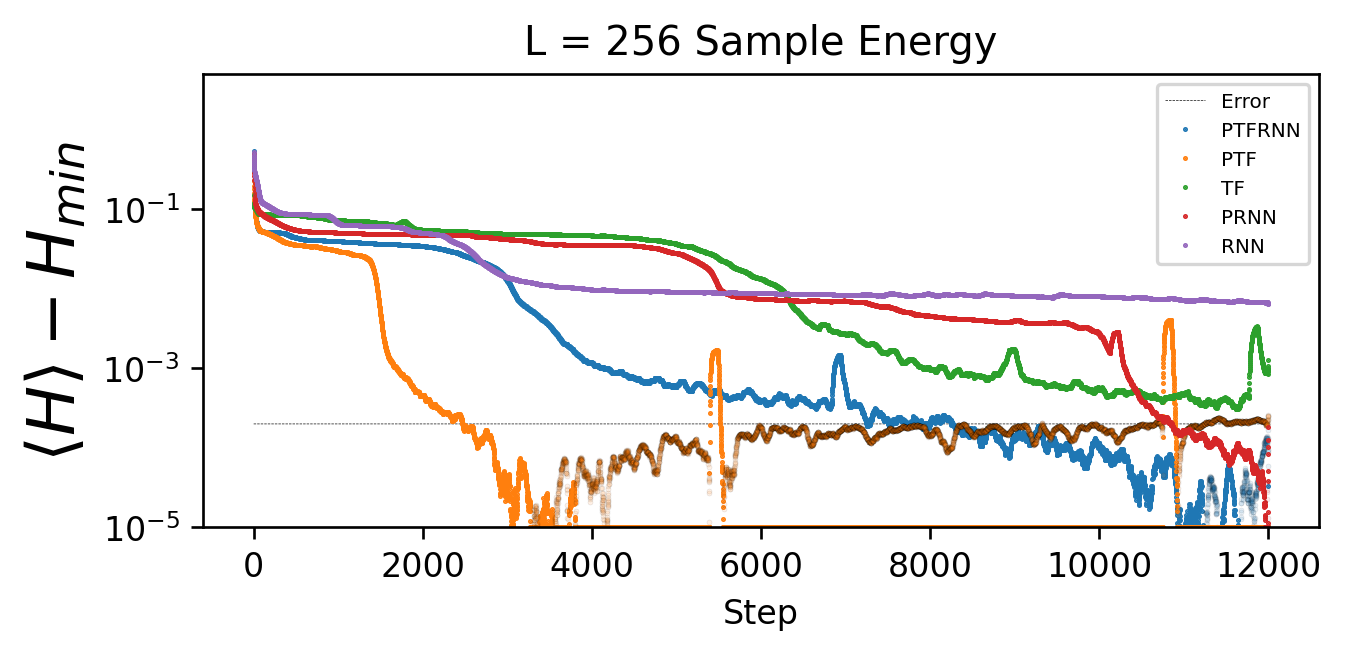

In [14]:
p = getpaths("PTFRNN\\Rydberg",["256-NoQ"])
p[256] += getpaths("PTF\\Rydberg",["256-NoQ","\\1"],alldir=True)[256]
p[256] += getpaths("TF\\Rydberg",["256","0.00\\R"],alldir=True)[256]
p[256] += getpaths("PRNN\\Rydberg",["256","333"],alldir=False)[256]
p[256] += getpaths("RNN\\Rydberg",["256","333"],alldir=False)[256]
graphs(p,useTimes=False, metric="Sample",label_idx=[0],err=False,smoothing=100)

True -0.3724
L=576 PTFRNN\Rydberg\576: -0.372703|L=576 PTF\Rydberg\576: -0.372818|


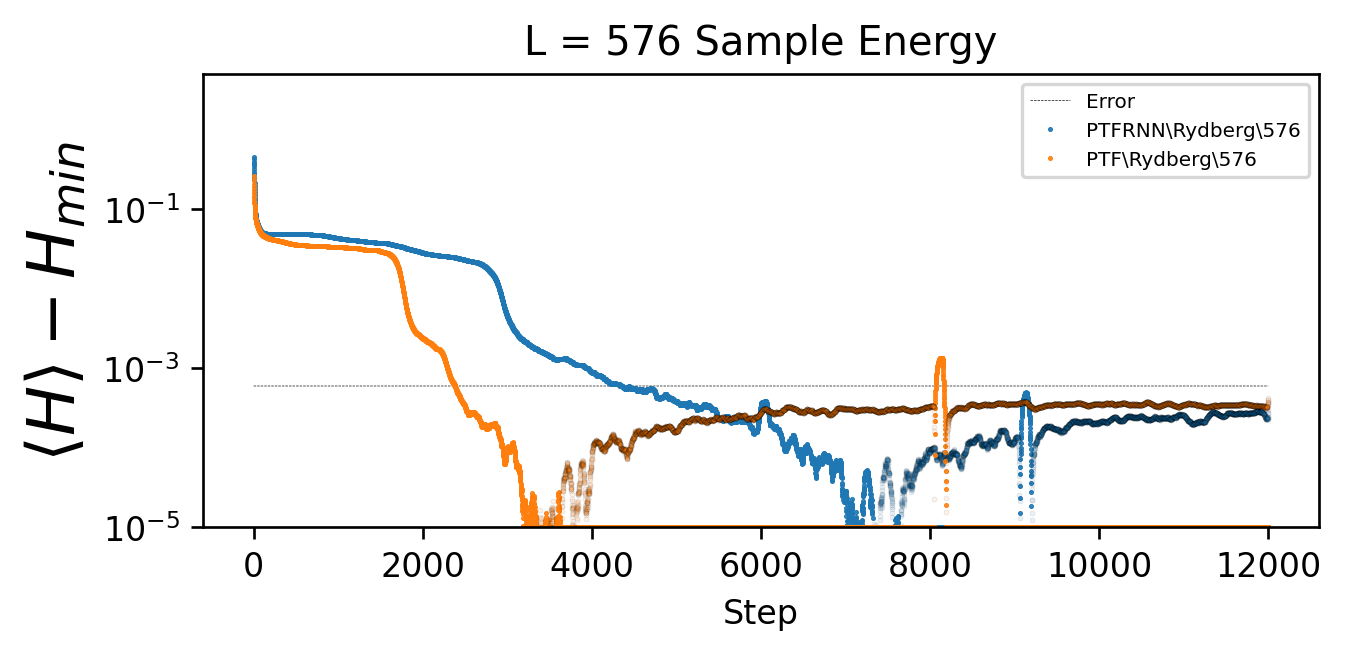

In [32]:
p = getpaths("PTFRNN\\Rydberg",["576"])
p[576] += getpaths("PTF\\Rydberg",["576"])[576]
graphs(p,useTimes=False, metric="Sample",label_idx=0,err=False,smoothing=100)

True -0.3687
L=1024 PTFRNN,kl=0.00: -0.368765|L=1024 PTF,kl=0.00: -0.368899|


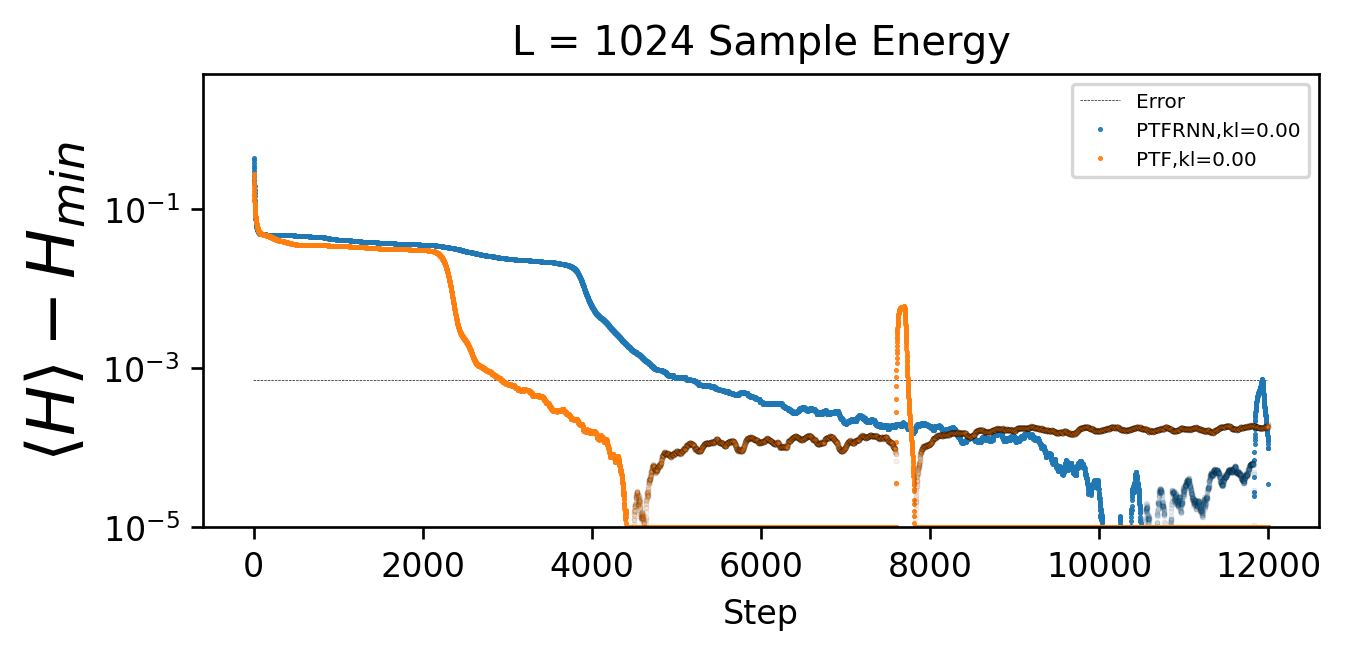

In [15]:
p = getpaths("PTFRNN\\Rydberg",["1024"])
p[1024] += getpaths("PTF\\Rydberg",["1024","K=128"],alldir=False)[1024]
graphs(p,useTimes=False, metric="Sample",label_idx=[0,-1],err=False,smoothing=100)

In [214]:

os.system("git commit -a -m \"Added kl divergence term\"")
os.system("git push origin")

0

# The regular transformer run was stopped and then continued so I had to manually combine the results

True -0.38052
L=256 TF,kl=0.00\0: -0.377569|L=256 TF,kl=0.00\1: -0.380210|L=256 TF,kl=0.00\R: -0.380210|


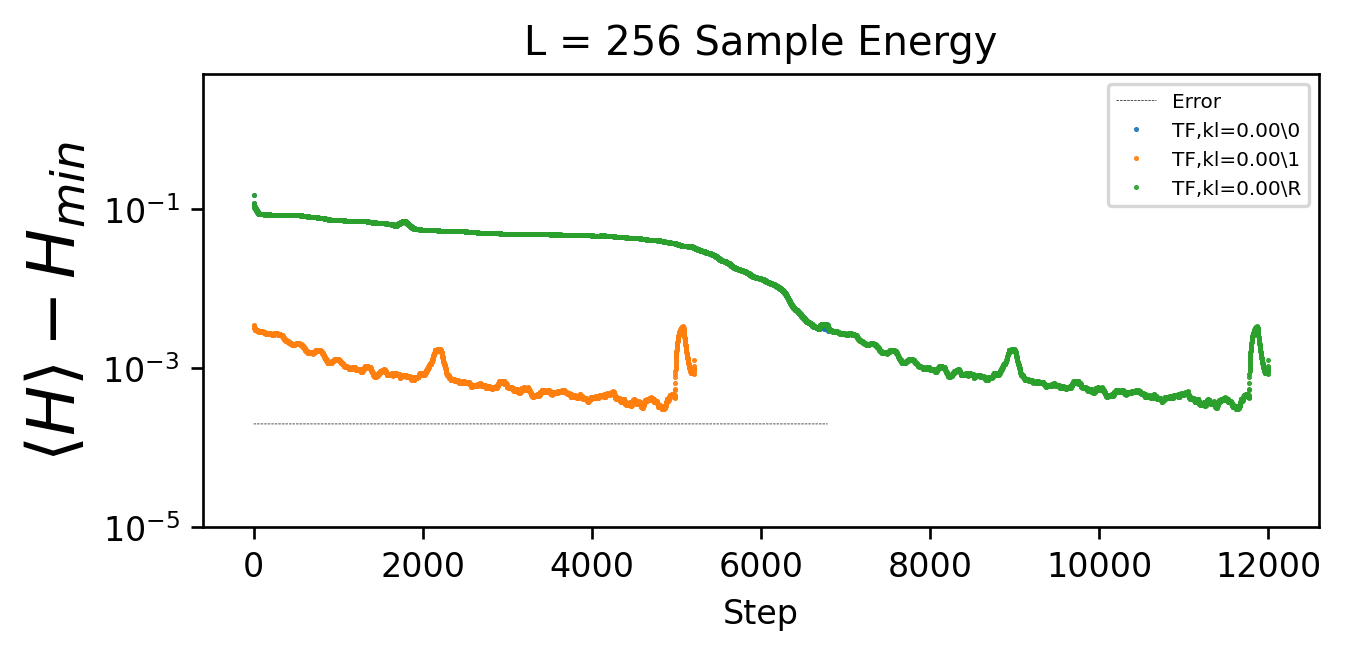

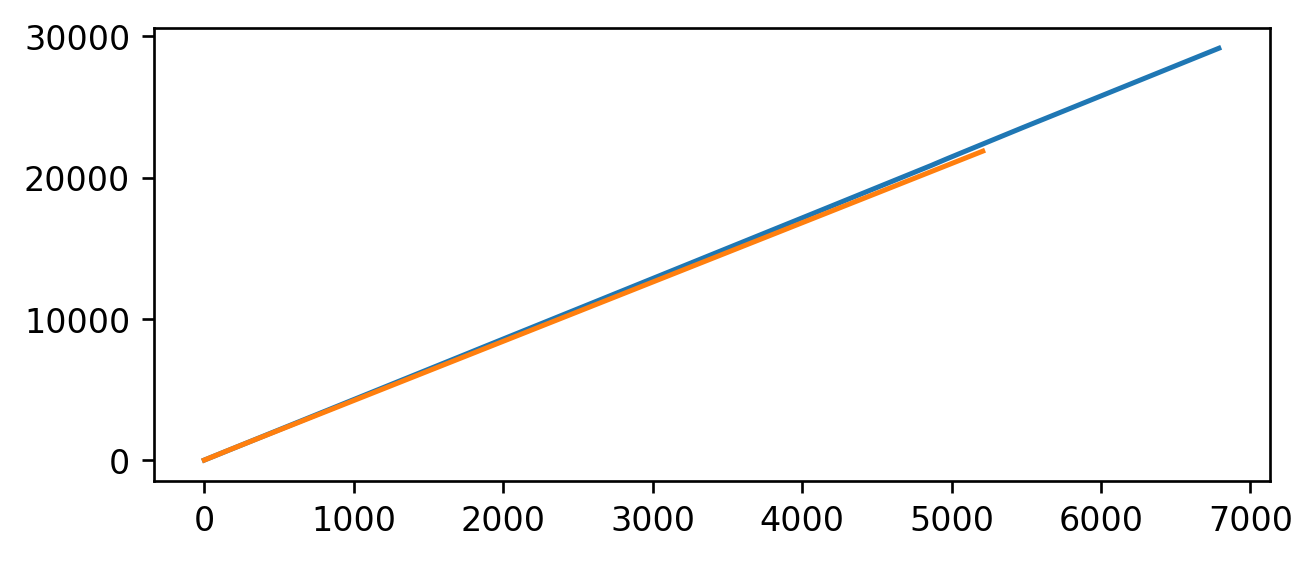

In [16]:
p=getpaths("TF\\Rydberg",["256","0.00\\"],alldir=True)
graphs(p,useTimes=False, metric="Sample",label_idx=[0,-1],err=False,smoothing=100)



fig = plt.figure(1,figsize=(6,2.5), dpi=240, facecolor='w', edgecolor='k')
debug0=np.load(p[256][0]+"\\DEBUG.npy")
debug1=np.load(p[256][1]+"\\DEBUG.npy")
plt.plot(debug0[:,-1])
plt.plot(debug1[:,-1])


#p = getpaths("PTFRNN\\Rydberg",["256","0.00\\"],alldir=True)
#debug2=np.load(p[256][0]+"\\DEBUG.npy")
#plt.plot(debug2[:,-1])


In [19]:
debug1[:,-1]+=debug0[-1,-1]

x = np.concatenate([debug0,debug1])

np.save("E:\\SharedContent\\NN-QSR\\TF\\Rydberg\\256-NoQ-B=256-K=256-Nh=128-kl=0.00\\R\\DEBUG.npy",x)